In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import json
import re
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings('ignore')

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Exploration / Preparation

In [2]:
# Download dataset and take a look at it

spotify_df = pd.read_csv('data.csv')
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


## Observations :

* This data is at a song level.
* There are many numerical features that I'll use to compare tracks (valence, acousticness, danceability, etc).
* Release date & Popularity will be useful but I'll need to create one-hot encoded features for them with a 5-unit step.
* There is nothing here related to the genre of the track which is available in data_w_genres dataset.
* Artists feature type should be transformed from object to list.

In [3]:
data_w_genres = pd.read_csv('data_w_genres.csv')
data_w_genres.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


## Observations :

* This data is at an artist level.
* There are similar continuous variables as the initial dataset of Spotify.
* The genres of tracks are going to be useful in the whole process, and I'll need to make them in the format of a list.

## Data description :

* <b>valence</b> : A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g sad, depressed, angry).
* <b>year</b> : Track release year.
* <b>acousticness</b> : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* <b>artists</b> : List of artists that contributed to a track.
* <b>danceability</b> : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* <b>duration_ms</b> : The duration of a track in milliseconds.
* <b>energy</b> : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* <b>explicit</b> : Whether or not a track contains curse words that is generally deemed sexual, violent, or effensive in nature.
* <b>id</b> : Track's id.
* <b>instrumentalness</b> : Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* <b>key</b> : The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C#/Db, 2 = D and so on.
* <b>liveness</b> : Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* <b>loudness</b> : The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 dB.
* <b>mode</b> : Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. Major mode has a bright and happy sound, while minor mode has a darker and sadder sound.
* <b>name</b> : Track's name.
* <b>popularity</b> : The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
* <b>release date</b> : Track's release date.
* <b>speechiness</b> : Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* <b>tempo</b> : The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* <b>genres</b> : Track's list of genres.

In [4]:
# Explore the datatypes of each variable in spotify_df dataset

spotify_df.dtypes

valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object

In [5]:
# Explore the datatypes of each variable in data_w_genres dataset

data_w_genres.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [6]:
# Extract the number of rows and columns in spotify_df dataset

print('Spotify dataset has {} rows and {} columns'.format(spotify_df.shape[0], spotify_df.shape[1]))

Spotify dataset has 170653 rows and 19 columns


In [7]:
# Extract the number of rows and columns in data_w_genres dataset

print('Data with genres dataset has {} rows and {} columns'.format(data_w_genres.shape[0], data_w_genres.shape[1]))

Data with genres dataset has 28680 rows and 16 columns


## genres feature :

In [8]:
# Change the genres feature type to a list

data_w_genres['genres_upd_v1'] = data_w_genres['genres'].apply(lambda x : [re.sub(' ', '_', i) for i in re.findall(r"'([^']*)'", x)])
data_w_genres['genres_upd_v1'][0]

['show_tunes']

## artists feature :

In [9]:
# Change the artists feature type to a list

spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x : [re.sub(' ', '_', i) for i in re.findall(r"'([^']*)'", x)])
spotify_df['artists_upd_v1'][0]

['Sergei_Rachmaninoff', 'James_Levine', 'Berliner_Philharmoniker']

Let's check once again if this process works well for every sample in both datasets.

In [10]:
# Check process for data_w_genres dataset

data_w_genres[data_w_genres['genres_upd_v1'].apply(lambda x : not x)]['genres'].value_counts()

[]                                 9857
["children's music"]                 25
["children's choir"]                  3
["muzika l'yeladim"]                  2
["canzone d'autore"]                  1
["preschool children's music"]        1
["australian children's music"]       1
["women's choir"]                     1
["children's story"]                  1
Name: genres, dtype: int64

In [11]:
# Check process for spotify_df dataset

spotify_df[spotify_df['artists_upd_v1'].apply(lambda x : not x)]['artists'].value_counts()

["Guns N' Roses"]                      80
["Anita O'Day"]                        67
["Booker T. & the M.G.'s"]             48
["The O'Jays"]                         47
["Sergio Mendes & Brasil '66"]         46
                                       ..
["Rockin' Sidney"]                      1
["Virginia O'Brien"]                    1
["Shawn Lee's Ping Pong Orchestra"]     1
["The 5.6.7.8's"]                       1
["The Feline Composer's Series"]        1
Name: artists, Length: 255, dtype: int64

We can see that it didn't catch all of them and the special thing about them is that they are enclosed in double quotes.

In [12]:
# Transform the rest of samples in both datasets

data_w_genres['genres_upd_v2'] = data_w_genres['genres'].apply(lambda x : [re.sub(' ', '_', i) for i in re.findall('\"(.*?)\"', x)])
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x : [re.sub(' ', '_', i) for i in re.findall('\"(.*?)\"', x)])

In [13]:
# Check again to see if it works for all samples in both datasets

print(data_w_genres[(data_w_genres['genres_upd_v1'].apply(lambda x : not x)) & (data_w_genres['genres_upd_v2'].apply(lambda x : not x))]['genres'].value_counts())
print(spotify_df[(spotify_df['artists_upd_v1'].apply(lambda x : not x)) & (spotify_df['artists_upd_v2'].apply(lambda x : not x))]['artists'].value_counts())

[]    9857
Name: genres, dtype: int64
Series([], Name: artists, dtype: int64)


In [14]:
# We can see that it works for all samples and now let's combine version 1 & 2 of updated genres & artists

data_w_genres['genres_upd'] = np.where(data_w_genres['genres_upd_v1'].apply(lambda x : not x), data_w_genres['genres_upd_v2'], data_w_genres['genres_upd_v1'])
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x : not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'])

## artists + nom features :

In [15]:
# Create a feature that combines the artist and song name, so we could use it as a new identifier because there are some duplicates that have different ids

spotify_df['artists_song'] = spotify_df.apply(lambda x : x['artists_upd'][0] + ' ' + x['name'], axis=1)
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"[Sergei_Rachmaninoff, James_Levine, Berliner_P...",[],"[Sergei_Rachmaninoff, James_Levine, Berliner_P...",Sergei_Rachmaninoff Piano Concerto No. 3 in D ...
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,[Dennis_Day],[],[Dennis_Day],Dennis_Day Clancy Lowered the Boom
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,1,Gati Bali,5,1921,0.0339,110.339,[KHP_Kridhamardawa_Karaton_Ngayogyakarta_Hadin...,[],[KHP_Kridhamardawa_Karaton_Ngayogyakarta_Hadin...,KHP_Kridhamardawa_Karaton_Ngayogyakarta_Hadini...
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,1,Danny Boy,3,1921,0.0354,100.109,[Frank_Parker],[],[Frank_Parker],Frank_Parker Danny Boy
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,[Phil_Regan],[],[Phil_Regan],Phil_Regan When Irish Eyes Are Smiling


In [16]:
# Sort values in spotify dataset descendingly according to artists_song & release date features

spotify_df.sort_values(['artists_song', 'release_date'], ascending=False, inplace=True)

In [17]:
# Drop duplicates on artists_song feature

spotify_df.drop_duplicates('artists_song', inplace=True)

Now, we'll explode artists column of spotify dataset so that every artist will have their own row and merge the result with the second dataset so it'll enriched with information related to track's genre.

In [18]:
# Explode artists column

artists_exploded = spotify_df[['artists_upd', 'id']].explode('artists_upd')
artists_exploded.head()

,artists_upd,id
164470,조정현,2ghebdwe2pNXT4eL34T7pW
150072,黑豹,3KIuCzckjdeeVuswPo20mC
159177,黃國隆,4prhqrLXYMjHJ6vpRAlasx
144483,黃國隆,5xFXTvnEe03SyvFpo6pEaE
144483,王秋玉,5xFXTvnEe03SyvFpo6pEaE


In [19]:
# Merge artists_exploded & data_w_genres datasets

artists_exploded_enriched = artists_exploded.merge(data_w_genres, how='left', left_on='artists_upd', right_on='artists')
artists_exploded_enriched_notnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]
artists_exploded_enriched_notnull.head()

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,...,speechiness,tempo,valence,popularity,key,mode,count,genres_upd_v1,genres_upd_v2,genres_upd
0,조정현,2ghebdwe2pNXT4eL34T7pW,['classic korean pop'],조정현,0.568000,0.447000,237688.000000,0.2150,0.000001,0.064900,...,0.027200,71.979000,0.177000,31.0,10.0,1.0,2.0,[classic_korean_pop],[],[classic_korean_pop]
1,黑豹,3KIuCzckjdeeVuswPo20mC,"['chinese indie', 'chinese indie rock']",黑豹,0.381000,0.353000,316160.000000,0.6860,0.000000,0.056800,...,0.039500,200.341000,0.352000,35.0,11.0,1.0,2.0,"[chinese_indie, chinese_indie_rock]",[],"[chinese_indie, chinese_indie_rock]"
2,黃國隆,4prhqrLXYMjHJ6vpRAlasx,[],黃國隆,0.785455,0.570818,174582.727273,0.1484,0.000083,0.142191,...,0.054355,119.586273,0.741273,23.0,5.0,1.0,11.0,[],[],[]
3,黃國隆,5xFXTvnEe03SyvFpo6pEaE,[],黃國隆,0.785455,0.570818,174582.727273,0.1484,0.000083,0.142191,...,0.054355,119.586273,0.741273,23.0,5.0,1.0,11.0,[],[],[]
4,王秋玉,5xFXTvnEe03SyvFpo6pEaE,[],王秋玉,0.885000,0.649500,150620.000000,0.1150,0.000000,0.092750,...,0.066100,121.090000,0.696500,23.0,7.0,0.0,4.0,[],[],[]


At this moment, we'll group the newly created dataframe by id, reset its index and then transform genres_upd into a feature with 1D list type.

In [20]:
# Group the newly made dataset by id and reset index

artists_genres_consolidated = artists_exploded_enriched_notnull.groupby('id')['genres_upd'].apply(list).reset_index()
artists_genres_consolidated.head()

,id,genres_upd
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn..."
2,000u1dTg7y1XCDXi80hbBX,"[[country, country_road, country_rock]]"
3,000x2qE0ZI3hodeVrnJK8A,"[[folk-pop, indie_folk, modern_rock, new_ameri..."
4,0024tEymsoc9FyKUauQngQ,"[[cyberpunk, new_age]]"


In [21]:
# Transform back genres_upd feature to 1D list

artists_genres_consolidated['genres_upd_list'] = artists_genres_consolidated['genres_upd'].apply(lambda x : list(set(list(itertools.chain.from_iterable(x)))))
artists_genres_consolidated.head()

,id,genres_upd,genres_upd_list
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[dance_rock, power_pop, new_wave_pop, new_wave..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn...","[alternative_hip_hop, conscious_hip_hop, minne..."
2,000u1dTg7y1XCDXi80hbBX,"[[country, country_road, country_rock]]","[country, country_rock, country_road]"
3,000x2qE0ZI3hodeVrnJK8A,"[[folk-pop, indie_folk, modern_rock, new_ameri...","[stomp_and_holler, indie_folk, modern_rock, ne..."
4,0024tEymsoc9FyKUauQngQ,"[[cyberpunk, new_age]]","[new_age, cyberpunk]"


In [22]:
# Let's enrich spotify dataset with information created based on thier genres

spotify_df = spotify_df.merge(artists_genres_consolidated[['id', 'genres_upd_list']], on='id', how='left')
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,genres_upd_list
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,...,그아픔까지사랑한거야,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현 그아픔까지사랑한거야,[classic_korean_pop]
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,...,DON'T BREAK MY HEART,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹 DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]"
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,...,藝旦調,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆 藝旦調,[]
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,...,草螟弄雞公,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆 草螟弄雞公,[]
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,...,思想起,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆 思想起,[]


# Feature Engineering

In [23]:
# A function that creates dummy variables

def ohe_prep(df, column, new_name):
    """
    Create One Hot Encoded Features of a specific column
    
    Parameters :
        df (Pandas dataframe) : Spotify dataset
        column (str) : column to be processed
        new_name (str) : new column name to be used
        
    Returns :
        ohe_df (Pandas dataframe) : One Hot Encoded features of that column
    """
    
    ohe_df = pd.get_dummies(df[column])
    feature_names = ohe_df.columns
    ohe_df.columns = [new_name + '|' + str(name) for name in feature_names]
    ohe_df.reset_index(drop=True, inplace=True)
    return ohe_df

In [24]:
# Extract column names of type float

float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values
float_cols

array(['valence', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'],
      dtype=object)

In [25]:
# Create 5 point buckets for popularity feature

spotify_df['popularity_bucket'] = spotify_df['popularity'].apply(lambda x : int(x/5))
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,genres_upd_list,popularity_bucket
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,...,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현 그아픔까지사랑한거야,[classic_korean_pop],6
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,...,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹 DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]",7
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,...,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆 藝旦調,[],4
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,...,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆 草螟弄雞公,[],4
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,...,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆 思想起,[],4


In [26]:
# Fill any null value in genres_upd_list with an empty list, so it can be handled by tfidf vectorizer

spotify_df['genres_upd_list'] = spotify_df['genres_upd_list'].apply(lambda x : x if isinstance(x, list) else [])

In [27]:
# Check the number of null values in each column of spotify dataset

spotify_df.isna().sum()

valence              0
year                 0
acousticness         0
artists              0
danceability         0
duration_ms          0
energy               0
explicit             0
id                   0
instrumentalness     0
key                  0
liveness             0
loudness             0
mode                 0
name                 0
popularity           0
release_date         0
speechiness          0
tempo                0
artists_upd_v1       0
artists_upd_v2       0
artists_upd          0
artists_song         0
genres_upd_list      0
popularity_bucket    0
dtype: int64

In [28]:
# Function to create entire feature set

def create_feature_set(df, float_cols):
    """
    Manage spotify dataframe to create a final set of features that will be used to make music recommendations.
    
    Parameters:
        df (Pandas dataframe) : Spotify dataset
        float_cols (list(str)) : List of column names of type float that will be normalized
    
    Returns :
        final_df (Pandas dataframe) : Final set of features that will be used to make recommendations
    """
    
    # generate tfidf features using genre lists
    tfidf = TfidfVectorizer()
    genre_matrix = tfidf.fit_transform(df['genres_upd_list'].apply(lambda x : " ".join(x)))
    feature_names = tfidf.get_feature_names()
    genre_df = pd.DataFrame(genre_matrix.toarray())
    genre_df.columns = ['genre|' + name for name in feature_names]
    genre_df.reset_index(drop=True, inplace=True)
    
    # create dummy variables for year & population features
    year_ohe = ohe_prep(df, 'year', 'year') * 0.5
    pop_ohe = ohe_prep(df, 'popularity_bucket', 'pop') * 0.15
    
    # normalize float features
    scaler = MinMaxScaler()
    floats = df[float_cols].reset_index(drop=True)
    floats_df = pd.DataFrame(scaler.fit_transform(floats), columns=float_cols) * 0.2
    
    # concatenate the results to get the final features set
    final_df = pd.concat([genre_df, floats_df, year_ohe, pop_ohe], axis=1)
    
    # Add song id to the newly created dataframe
    final_df['id'] = df['id']
    
    return final_df

In [29]:
# Get the features set that will be used to make music recommendation

spotify_final_df = create_feature_set(spotify_df, float_cols)
spotify_final_df.head()

,genre|_hip_hop,genre|a_cappella,genre|abstract,genre|abstract_beats,genre|abstract_hip_hop,genre|acid_house,genre|acid_rock,genre|acoustic_pop,genre|acoustic_punk,genre|adoracion,...,pop|12,pop|13,pop|14,pop|15,pop|16,pop|17,pop|18,pop|19,pop|20,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2ghebdwe2pNXT4eL34T7pW
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3KIuCzckjdeeVuswPo20mC
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4prhqrLXYMjHJ6vpRAlasx
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5xFXTvnEe03SyvFpo6pEaE
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6Pqs2suXEqCGx7Lxg5dlrB


# Connect to Spotify API

In [30]:
# Define authentification credentials for our application

client_id = 'b561c94900ee4651be72bc406fa8a795'
client_secret= '71a6c49c5b1c4dd588193325d0b25f88'

In [31]:
# Define the scope that a normal user is allowed to be into and make a statement that manages every error that may occur

scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [32]:
# Connect to the Spotify API using the client id and password defined above

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

Now, we should create a Spotify web app that manages our playlists using this website :
<a href=https://developer.spotify.com/dashboard/ >Spotify Developer Dashboard</a>.
Also, we have to create some playlists that have some songs which are available in our spotify_df dataset.

In [33]:
# Extract user's token that we don't have to authentificate every time we want to connect to Spotify API and use it to reconnect

token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')
sp = spotipy.Spotify(auth=token)

In [34]:
# Gather my playlists' names & images

id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:
    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']
    
id_name

{'My Playlist #1': '4JDCYBMJfCOSpMPIYAKpz9'}

In [35]:
# Create a function that pulls songs out from a playlist and not all songs, only the ones that are available in Spotify dataset

def pull_songs_playlist(playlist_name, dic_name_id, df):
    """
    Pull songs from a specific playlist.
    
    Parameters :
        playlist_name (str) : Name of the playlist that we want to pull songs out of
        dic_name_id (dictionary) : Dictionary that maps every playlist name to their id
        df (Pandas Dataframe) : Spotify Dataset
        
    Returns :
        playlist_songs (Pandas Dataframe) : Dataset that contains all songs in a specific playlist that are available in spotify dataset
    """
    
    # Pull all songs from my playlist
    playlist_songs = pd.DataFrame()
    for idx, i in enumerate(sp.playlist(dic_name_id[playlist_name])['tracks']['items']):
        playlist_songs.loc[idx, 'artist'] = i['track']['artists'][0]['name']
        playlist_songs.loc[idx, 'name'] = i['track']['name']
        playlist_songs.loc[idx, 'id'] = i['track']['id']
        playlist_songs.loc[idx, 'url'] = i['track']['album']['images'][1]['url']
        playlist_songs.loc[idx, 'date_added'] = i['added_at']
    
    # Transform date_added column to be of type 'Date'
    playlist_songs['date_added'] = pd.to_datetime(playlist_songs['date_added'])
    
    # Filter out playlist_songs dataset so that contains only songs that are available in Spotify dataset and sort it descendingly by the date when it had been added to the considered playlist
    playlist_songs = playlist_songs[playlist_songs['id'].isin(df['id'])].sort_values('date_added', ascending=False)
    
    return playlist_songs

In [36]:
# Pull out songs from My Playlist #1 playlist

playlist_1 = pull_songs_playlist('My Playlist #1', id_name, spotify_df)
playlist_1

,artist,name,id,url,date_added
4,The Weeknd,Call Out My Name,09mEdoA6zrmBPgTEN5qXmN,https://i.scdn.co/image/ab67616d00001e021f6a2a...,2024-07-20 10:52:16+00:00
3,The Weeknd,Save Your Tears,5QO79kh1waicV47BqGRL3g,https://i.scdn.co/image/ab67616d00001e028863bc...,2024-07-20 10:52:15+00:00
1,Drake,God's Plan,6DCZcSspjsKoFjzjrWoCdn,https://i.scdn.co/image/ab67616d00001e02f907de...,2024-07-20 10:51:44+00:00


In [37]:
# Create a function that visualizes songs' cover photos that are already pulled out from a specific playlist

import PIL
import urllib

def visualize_songs(df):
    """
    Visualize songs' cover photos available in a dataframe.
    
    Parameters :
        df (Panadas Dataframe) : Dataset that contains metadata about a list of songs pulled out from a playlist
    """
    columns = 3
    for i, url in enumerate(df['url']):
        plt.subplot(int(len(df['url']) / columns) , columns, i + 1)
        image = np.array(PIL.Image.open(urllib.request.urlopen(url)))
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)
    
    plt.show()

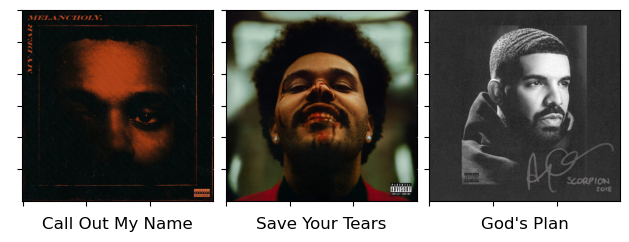

In [38]:
# Visualize cover photos of songs that have been pulled out from my playlist 'My Playlist #1'

visualize_songs(playlist_1)

# Create Playlist Vector

In [39]:
# A function that transforms our feature set to a single representative vector

def generate_playlist_vector(final_spotify_df, playlist_df, weight_factor):
    """
    Summarize a user's playlist into a single vector.
    
    Parameters :
        final_spotify_df (Pandas Dataframe) : Dataset that contains all spotify features to use in the recommendation process
        playlist_df (Pandas dataframe) : Dataset that contains all songs' metadata from my playlist extracted using spotify API
        weight_factor (float) : It represents the recency bias. The larger the recency bias is, the recently added songs will be added. Value should be close to 1.
    
    Returns :
        playlist_feature_set_weighted_final (Pandas Series) : Single vector that summarizes the playlist
        complete_feature_set_nonplaylist (Pandas Dataframe) : Dataset that contains all spotify features for songs that are not available in our playlist
    """
    
    complete_feature_set_playlist = final_spotify_df[final_spotify_df['id'].isin(playlist_df['id'])]
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id', 'date_added']], on='id', how='inner')
    complete_feature_set_nonplaylist = final_spotify_df[~final_spotify_df['id'].isin(playlist_df['id'])]
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added', ascending=False)
    most_recent_date = playlist_feature_set.loc[0, 'date_added']
    
    for idx, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[idx, 'months_from_recent'] = int((most_recent_date.to_pydatetime() - row['date_added'].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x : weight_factor ** (-x))
    
    playlist_feature_set.update(playlist_feature_set.iloc[:, :-4].mul(playlist_feature_set.weight, 0))
    playlist_feature_set_weighted_final = playlist_feature_set.iloc[:, :-4].sum(axis=0)
    
    return playlist_feature_set_weighted_final, complete_feature_set_nonplaylist

In [40]:
# Create our weighted vector for my playlist

playlist_feature_set_weighted_final_playlist_1, complete_feature_set_nonplaylist_playlist_1 = generate_playlist_vector(spotify_final_df, playlist_1, 1.09)
playlist_feature_set_weighted_final_playlist_1.head()

genre|_hip_hop            0.0
genre|a_cappella          0.0
genre|abstract            0.0
genre|abstract_beats      0.0
genre|abstract_hip_hop    0.0
dtype: float64

# Generate Recommendations

Now, we'll compare my playlist vector to individual songs in our spotify dataset using Cosine Similarity score; The higher the score, the smaller the angle between both vectors and the more similar a song to my playlist's tracks.

In [48]:
# Fucntion that calculates the cosine similarity scores between my playlist's tracks & other songs in spotify dataset and return top 24 recommendations for that playlist

def generate_recommendations(df, features, nonplaylist_features):
    """
    Make a recommendation of most similar 24 songs to my playlist.
    
    Parameters :
    df (Pandas Dataframe) : Spotify dataset
    features (Pandas Series) : A vector that summarizes tracks in my playlist
    nonplaylist_features (Pandas Dataframe) : Dataset that contains features related to tracks not available in my playlist
    
    Returns :
    top_24_tracks_df (Pandas Dataframe) : A list of 24 songs as a recommendation for my playlist
    """
    
    nonplaylist_df = df[df['id'].isin(nonplaylist_features['id'])]
    nonplaylist_df['cosine_sim'] = cosine_similarity(nonplaylist_features.drop('id', axis=1).values, features.values.reshape(1, -1))[:, 0]
    top_24_tracks_df = nonplaylist_df.sort_values('cosine_sim').tail(24)
    
    return top_24_tracks_df

In [49]:
# Generate top 24 tracks that are similar to songs which are available in my playlist

top_24_tracks_df_playlist_1 = generate_recommendations(spotify_df, playlist_feature_set_weighted_final_playlist_1, complete_feature_set_nonplaylist_playlist_1)
top_24_tracks_df_playlist_1

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,genres_upd_list,popularity_bucket,cosine_sim
121931,0.1380,2018,0.49300,"['Drake', 'Michael Jackson']",0.822,245787,0.318,0,6G8kHiVZ1jW7vHMPVRNZU0,0.012800,...,2018-06-29,0.0575,102.998,"[Drake, Michael_Jackson]",[],"[Drake, Michael_Jackson]",Drake Don’t Matter To Me (with Michael Jackson),"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",14,0.832428
121898,0.0371,2018,0.03700,['Drake'],0.764,262453,0.271,1,4c2xt1trwYZpMqPWY35Xi9,0.000000,...,2018-06-29,0.0414,116.019,[Drake],[],[Drake],Drake Jaded,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",13,0.834335
121930,0.0542,2018,0.01520,['Drake'],0.758,184960,0.474,1,3szf2z1Cy1QMrtHrbn8rz9,0.000000,...,2018-06-29,0.1470,76.061,[Drake],[],[Drake],Drake Elevate,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",12,0.834687
121836,0.1450,2018,0.13300,['Drake'],0.555,136187,0.596,1,2yg9UN4eo5eMVJ7OB4RWj3,0.000000,...,2018-06-29,0.3750,77.324,[Drake],[],[Drake],Drake Survival,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",12,0.834732
121921,0.2990,2018,0.13300,['Drake'],0.807,182080,0.319,0,2WP8G2pdddDmnh1xbfKBOI,0.000338,...,2018-06-29,0.0581,94.992,[Drake],[],[Drake],Drake Finesse,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",14,0.837478
121929,0.0853,2018,0.02480,['Drake'],0.414,302173,0.677,1,5Psnhdkyanjpgc2P8A5TSM,0.000000,...,2018-06-29,0.2540,172.521,[Drake],[],[Drake],Drake Emotionless,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",13,0.837930
121839,0.1340,2018,0.47700,['Drake'],0.776,247893,0.482,0,4HG1YiGBseVKzjyKcmAJen,0.045600,...,2018-06-29,0.0357,136.008,[Drake],[],[Drake],Drake Summer Games,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",12,0.838407
121954,0.1230,2018,0.01300,['Drake'],0.889,162800,0.372,1,4n1bdaKwynQndm47x5HqWX,0.000000,...,2018-06-29,0.3570,133.997,[Drake],[],[Drake],Drake Blue Tint,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",12,0.839685
121961,0.3360,2018,0.04070,"['Drake', 'Static Major', 'Ty Dolla $ign']",0.687,289560,0.429,1,3mvYQKm8h6M5K5h0nVPY9S,0.000000,...,2018-06-29,0.1920,141.966,"[Drake, Static_Major, Ty_Dolla_$ign]",[],"[Drake, Static_Major, Ty_Dolla_$ign]",Drake After Dark (feat. Static Major & Ty Doll...,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",12,0.840067
121831,0.3800,2018,0.11700,['Drake'],0.850,157605,0.473,1,41a7dZcq30Ss5kPMayWRV0,0.010300,...,2018-06-29,0.2090,85.454,[Drake],[],[Drake],Drake That’s How You Feel,"[canadian_hip_hop, canadian_pop, rap, pop_rap,...",12,0.844031
